# NFSClustering
This notebook shows the process followed in order to generate a non-supervised clustering of NFS Research Awards Abstracts. The information was downloaded from [here](https://archive.ics.uci.edu/ml/datasets/NSF+Research+Award+Abstracts+1990-2003) into a directory called *Data* and preprocessed to a directory called *preparedData* using the *dataExtract.py* script.

Firstly, all the necessary libraries are imported

In [53]:
import spacy, glob, seaborn, string, numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

## Prepocessing
The preprocessed data is loaded into the *corpus* variable and filtered all the empty or 'Not available' abstracts,  the numbers and the punctuation marks are also remove

In [5]:
nlp = spacy.load('en_core_web_md')

corpus = []

for filename in glob.glob("preparedData/awd_1992*.txt"):
    with open(filename, "r") as file:
        corpus.extend(file.readlines())

corpus = [x for x in corpus if len(x)>50]
corpus = [x.lower().strip() for x in corpus]
corpus = [x.translate(str.maketrans('', '', string.digits + string.punctuation)) for x in corpus]

print(f"Total abstract available {len(corpus)}")

Total abstract available 9986


## Spacy model
Using the spacy library, each abstract is tokenized and its word embeddings are obtained. To avoid the influence of repeated words into the same abstract, they are filtered to garantee that only appers once

In [6]:
data = []
for doc in nlp.pipe(corpus, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "ner"]):
    # Do something with the doc here
    tokenize_abstract =  [x for x in doc if (not x.is_stop) and (len(x.text) > 1)]
    data.append(tokenize_abstract)

In [7]:
non_duplicated_data = []
for abstract in data:
    unique_tokens = []
    unique_lemmas = []
    for token in abstract:
        if token.lemma_ not in unique_lemmas:
            unique_lemmas.append(token.lemma_)
            unique_tokens.append(token)
    non_duplicated_data.append(unique_tokens)

## Data visualization
In order to gain some context about the data a histogram that shows the length of each abstract and a word cloud are generated

<AxesSubplot:ylabel='Count'>

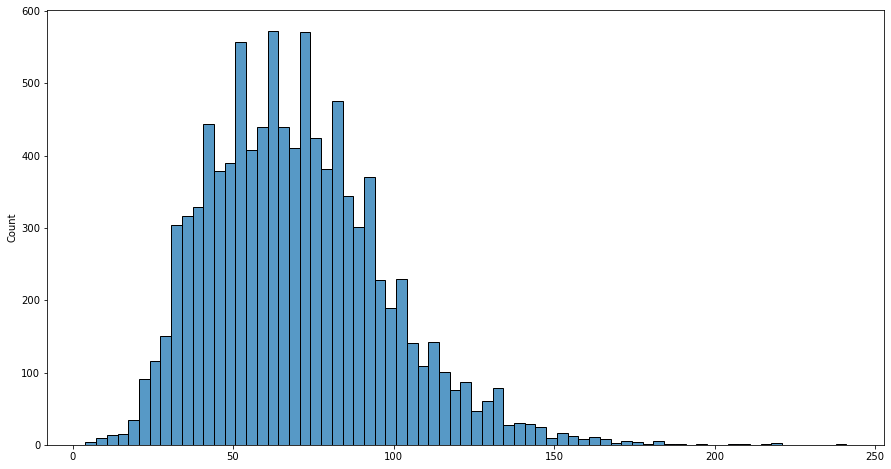

In [8]:
data_lengths = list(map(len, non_duplicated_data))
plt.figure(figsize=(15,8))
seaborn.histplot(data_lengths)

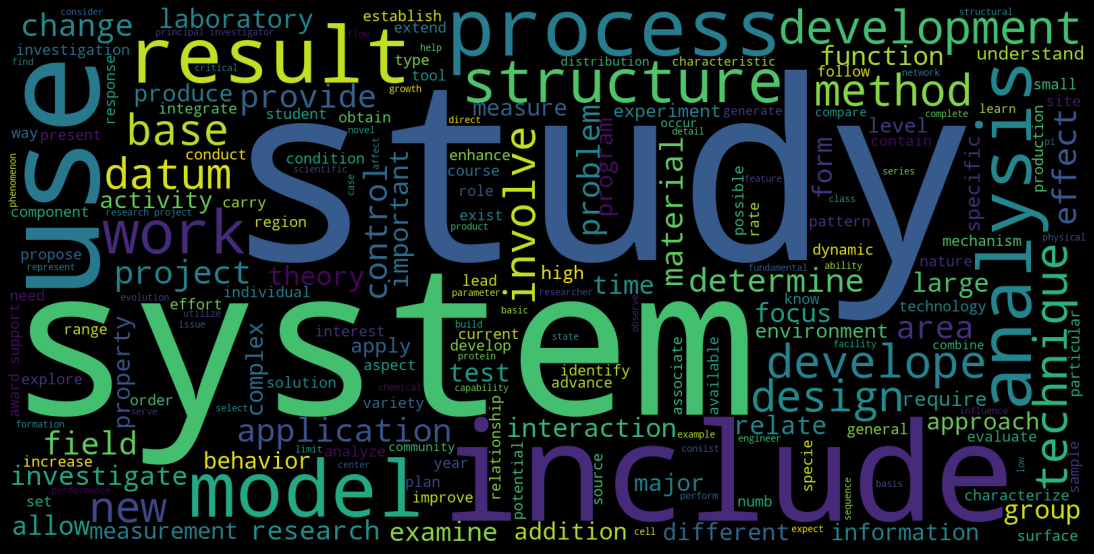

In [60]:
raw_data = " ".join([word.lemma_ for sentence in non_duplicated_data for word in sentence])
wordcloud = WordCloud(width=1600, height=800).generate(raw_data)

plt.figure( figsize=(15,8), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Data vectorization
In order to obtain a vector representation of each abstract, the mean of the word embeddings are calculated. This process result in a 300 dimensional vector for each abstract that is reduce using PCA. Several values are tried and 100 components were  selected based on the variance explained with these components

In [10]:
word_embeddings = [[word.vector for word in abstract if word.has_vector] for abstract in non_duplicated_data]
abstracts_centroids = [np.mean(embeddings, axis=0) for embeddings in word_embeddings if len(embeddings)]

In [11]:
pca = PCA(n_components=100)
reduced_crentroids = pca.fit_transform(abstracts_centroids)
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Total variance explained {explained_variance:.{2}}")

Total variance explained 0.92


## Vector visualization
Aiming to achieve a visual representation of the abstracts that matains its high-dimensional structure an TNSE algorith was trained on the dataset. Nevertheless, although the parameters tunning it wasn't possible to produce a visualization in wich the clusters are easily seen.

<AxesSubplot:>

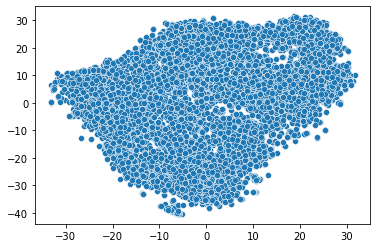

In [73]:
tsne = TSNE(perplexity=100, random_state=6384, learning_rate=50)
condensed_vectors = tsne.fit_transform(reduced_crentroids)
seaborn.scatterplot(x=condensed_vectors[:,0], y=condensed_vectors[:,1])

## Weigthed representation
In order to obtain a more precise vector representation that ignores common words used into the corpus a TF-IDF vectorization is combined with the embeddings to generate a weigthed average 300 dimensional vector for each abstract

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_data = [" ".join([word.lemma_ for word in abstract if word.has_vector]) for abstract in non_duplicated_data]
tfidf_vocab = set(raw_data.split())
tfidf_vectorizer = TfidfVectorizer(lowercase=False, vocabulary=tfidf_vocab)
tfidf_embeddings = tfidf_vectorizer.fit_transform(tfidf_data).toarray()

In [15]:
bag_of_words = tfidf_vectorizer.get_feature_names()
index_bag_of_word_dict = dict(map(reversed, enumerate(bag_of_words)))
tfidf_representation = []

for abstract, tfidf_embedding in zip(non_duplicated_data, tfidf_embeddings):
    positions = [index_bag_of_word_dict.get(word.lemma_) for word in abstract if word.has_vector]
    tfidf_representation.append(tfidf_embedding[positions])

In [24]:
abstracts_weighted_centroids = [np.average(embeddings, axis=0, weights=weights) 
                                for embeddings, weights in zip(word_embeddings, tfidf_representation)
                                if len(embeddings)]


In [40]:
pca = PCA(n_components=140)
reduced_weighted_crentroids = pca.fit_transform(abstracts_weighted_centroids)
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Total variance explained {explained_variance:.{2}}")

Total variance explained 0.94


In [50]:
tsne = TSNE(n_components=3,perplexity=100, random_state=6384, learning_rate=10)
condensed_vectors = tsne.fit_transform(reduced_weighted_crentroids)

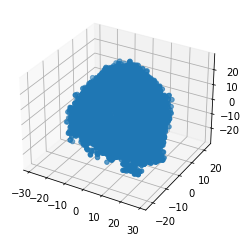

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(condensed_vectors[:,0], condensed_vectors[:,1], condensed_vectors[:,2])
plt.show()

## Data clustering
A K-Means algorithm was used to cluster the data, the elbow method was used to determine the best number of clusters to generate

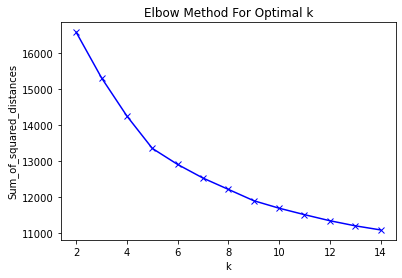

In [66]:
sum_of_squared_distances = []
K = range(2,15)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   km = km.fit(reduced_weighted_crentroids)
   sum_of_squared_distances.append(km.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [69]:
best_k = 5
model = KMeans(n_clusters=best_k, max_iter=200, n_init=10)
model.fit(reduced_weighted_crentroids)
labels=model.labels_

Finally a word cloud is generated for each cluster to understand the characteristics of each group of abstracts

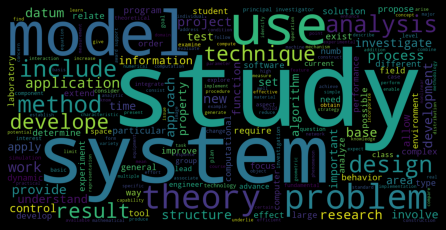

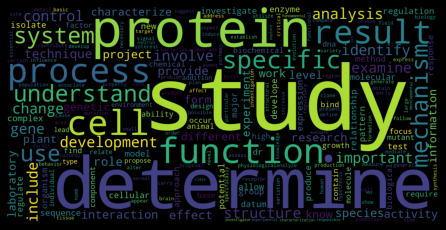

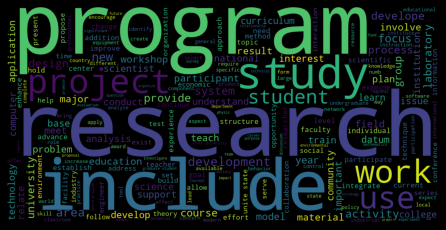

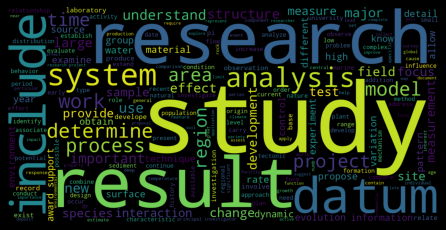

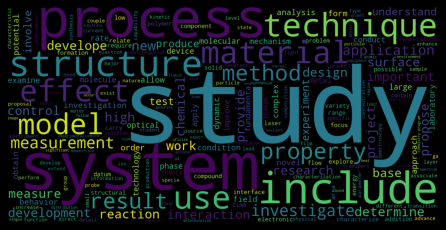

In [71]:
for k in range(0,best_k):
   abstracts = [abstract for abstract, label in zip(tfidf_data, labels) if label == k]
   text = " ".join(abstracts)
   wordcloud = WordCloud(width=1600, height=800).generate(text)

   plt.figure(facecolor='k')
   plt.imshow(wordcloud)
   plt.axis("off")
   plt.tight_layout(pad=0)
   plt.show()